In [1]:
import numpy as np
import os
# Imports nécessaires pour construire un modèle LeNet 
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Input
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import MaxPooling2D
from tensorflow.keras.layers import Rescaling, BatchNormalization

# Pour importer le datasets
import tensorflow as tf
from tensorflow.keras.preprocessing import image_dataset_from_directory

# Pour la compilation du modèle
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping

# Pour visualiser les performances
import matplotlib.pyplot as plt
from matplotlib import cm
%matplotlib inline

print(tf.__version__)
tf.config.experimental.set_memory_growth(tf.config.list_physical_devices('GPU')[0], True)
tf.keras.backend.clear_session()
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))

# Chargement du dataset
dir_name = "/mnt/c/Users/karim/rakuten/images/data_clean/images_deep/sample"
#dir_name = "/mnt/c/Users/karim/rakuten/images/data_clean/images_deep/train"
img_size = (224, 224)  # Taille cible
batch_size = 128
class_names = sorted(os.listdir(dir_name))
nb_class = len(class_names)

print(class_names)

train_ds = image_dataset_from_directory(
    dir_name,
    image_size=img_size,
    batch_size=batch_size,
    subset="training",
    validation_split=0.2,
    seed=42
)

val_ds = image_dataset_from_directory(
    dir_name,
    image_size=img_size,
    batch_size=batch_size,
    subset="validation",
    validation_split=0.2,
    seed=42
)

# Ajout d'optimisation : mise en cache et préchargement
#train_ds = train_ds.cache().prefetch(buffer_size=tf.data.AUTOTUNE)
#val_ds = val_ds.cache().prefetch(buffer_size=tf.data.AUTOTUNE)

2025-03-21 16:22:29.368990: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1742570549.553572    5577 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1742570549.608568    5577 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1742570549.996795    5577 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1742570549.996854    5577 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1742570549.996856    5577 computation_placer.cc:177] computation placer alr

2.19.0
Num GPUs Available:  1
['10', '40', '50']
Found 6851 files belonging to 3 classes.
Using 5481 files for training.


I0000 00:00:1742570564.472626    5577 gpu_device.cc:2019] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 5563 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 4060, pci bus id: 0000:01:00.0, compute capability: 8.9


Found 6851 files belonging to 3 classes.
Using 1370 files for validation.


## Version custom de LeNet

In [2]:
###  Architecture du model ###
inputs = Input(shape=(224, 224, 3))

# Data augmentation
data_augmentation = tf.keras.Sequential([
    tf.keras.layers.RandomFlip("horizontal"),
    tf.keras.layers.RandomRotation(0.2),
    tf.keras.layers.RandomZoom(0.2),
    tf.keras.layers.RandomContrast(0.2),
])

# Extraction des caractéristqiues
x = data_augmentation(inputs)
# Normalisation 
x = Rescaling(1./255)(x) 

# Première couche de convolution
x = Conv2D(
    filters=30,                    
    kernel_size=(5, 5),            
    padding='valid',               
    activation='relu',            
)(x)
x = MaxPooling2D(pool_size=(2, 2),)(x)
x = Dropout(0,2)(x)

# Deuxième couche de convolution
x = Conv2D(
    filters=16,                    
    kernel_size=(5, 5),            
    padding='valid',               
    activation='relu',            
)(x)
x = MaxPooling2D(pool_size=(2, 2),)(x)
x = Dropout(0,2)(x)

# Applatissement 
x = Flatten()(x)

# Couches dense pour la prédiction 
dense_128 = Dense(
    units=128,
    activation='relu',
)

# Couche de sortie
outputs = Dense(
    units=3,
    activation='softmax',
)(x)

reduce_learning_rate = ReduceLROnPlateau(
                                    monitor="val_loss",
                                    patience=3,
                                    min_delta=0.01,
                                    factor=0.5, 
                                    cooldown=4)

model_lenet = Model(inputs=inputs, outputs=outputs)

model_lenet.compile(
    loss='sparse_categorical_crossentropy',  
    optimizer="adam",                 
    metrics=['accuracy'])             

model_lenet_history = model_lenet.fit(train_ds,           # données
                           validation_data=val_ds,
                           epochs=30,
                           callbacks=[reduce_learning_rate])             # taille des batchs


Epoch 1/30


I0000 00:00:1742570601.690867    5933 cuda_dnn.cc:529] Loaded cuDNN version 90800
2025-03-21 16:23:24.814771: W external/local_xla/xla/tsl/framework/bfc_allocator.cc:382] Garbage collection: deallocate free memory regions (i.e., allocations) so that we can re-allocate a larger region to avoid OOM due to memory fragmentation. If you see this message frequently, you are running near the threshold of the available device memory and re-allocation may incur great performance overhead. You may try smaller batch sizes to observe the performance impact. Set TF_ENABLE_GPU_GARBAGE_COLLECTION=false if you'd like to disable this feature.


43/43 ━━━━━━━━━━━━━━━━━━━━ 14s 179ms/step - accuracy: 0.3739 - loss: 1.3557 - val_accuracy: 0.3818 - val_loss: 1.0533 - learning_rate: 0.0010
Epoch 2/30
43/43 ━━━━━━━━━━━━━━━━━━━━ 5s 112ms/step - accuracy: 0.4347 - loss: 1.0530 - val_accuracy: 0.4511 - val_loss: 1.0451 - learning_rate: 0.0010
Epoch 3/30
43/43 ━━━━━━━━━━━━━━━━━━━━ 5s 113ms/step - accuracy: 0.4848 - loss: 1.0123 - val_accuracy: 0.4504 - val_loss: 1.0414 - learning_rate: 0.0010
Epoch 4/30
43/43 ━━━━━━━━━━━━━━━━━━━━ 5s 112ms/step - accuracy: 0.4892 - loss: 1.0035 - val_accuracy: 0.5328 - val_loss: 0.9654 - learning_rate: 0.0010
Epoch 5/30
43/43 ━━━━━━━━━━━━━━━━━━━━ 5s 111ms/step - accuracy: 0.5393 - loss: 0.9578 - val_accuracy: 0.5679 - val_loss: 0.9045 - learning_rate: 0.0010
Epoch 6/30
43/43 ━━━━━━━━━━━━━━━━━━━━ 5s 111ms/step - accuracy: 0.5815 - loss: 0.8938 - val_accuracy: 0.5416 - val_loss: 0.9723 - learning_rate: 0.0010
Epoch 7/30
43/43 ━━━━━━━━━━━━━━━━━━━━ 11s 261ms/step - accuracy: 0.5759 - loss: 0.9249 - val_accur

## Analyse de l'entrainement

11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 51ms/step - accuracy: 0.7030 - loss: 0.7307 
Précision de validation finale: 0.6839


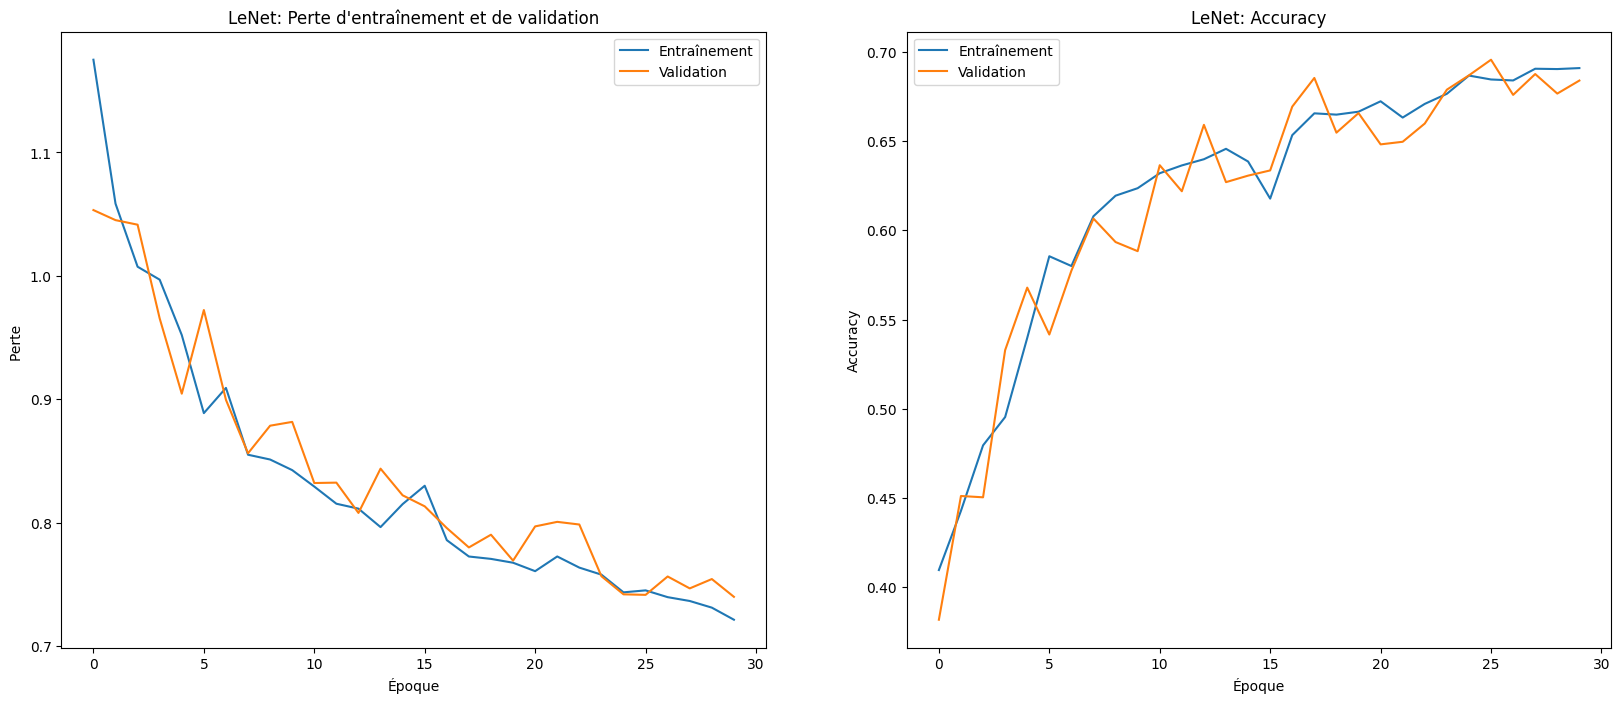

In [3]:
def display_results(model_history, model_name):
    # Récupérer les données d'entraînement et de validation
    train_loss = model_history.history["loss"]
    val_loss = model_history.history["val_loss"]
    train_accuracy =  model_history.history["accuracy"]
    val_accuracy = model_history.history["val_accuracy"]
    
    plt.figure(figsize=(20, 8))
    
    # Tracer la perte
    plt.subplot(121)
    plt.plot(train_loss)
    plt.plot(val_loss)
    plt.title(model_name + ": Perte d'entraînement et de validation")
    plt.ylabel('Perte ')
    plt.xlabel('Époque')
    plt.legend(['Entraînement', 'Validation'], loc='best')
    
    # Tracer l'erreur absolue moyenne (MAE)
    plt.subplot(122)
    plt.plot(train_accuracy)
    plt.plot(val_accuracy)
    plt.title(model_name+': Accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Époque')
    plt.legend(['Entraînement', 'Validation'], loc='best')
    
    plt.show()



# modèle LeNet
val_loss, val_accuracy = model_lenet.evaluate(val_ds)
print(f"Précision de validation finale: {val_accuracy:.4f}")
display_results(model_lenet_history, "LeNet")


## Analyse de la performance par classe

In [ ]:
from sklearn.metrics import confusion_matrix, classification_report
import matplotlib.pyplot as plt
import seaborn as sns

# 1. Générer des prédictions sur l'ensemble de validation
# Prévoir les classes pour tous les échantillons de validation
predictions = []
labels = []

# Récupérer toutes les étiquettes et prédictions
for images, true_labels in val_ds:
    pred = model.predict(images)
    pred_classes = np.argmax(pred, axis=1)
    
    predictions.extend(pred_classes)
    labels.extend(true_labels.numpy())

# Convertir en arrays numpy
predictions = np.array(predictions)
labels = np.array(labels)

# 2. Créer et afficher la matrice de confusion
cm = confusion_matrix(labels, predictions)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['Classe 0', 'Classe 1', 'Classe 2'],
            yticklabels=['Classe 0', 'Classe 1', 'Classe 2'])
plt.xlabel('Prédiction')
plt.ylabel('Réalité')
plt.title('Matrice de confusion')
plt.show()